In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import struct
import sys
from array import array

import itertools
import os
import sys
import ult
from scipy import signal
from scipy.optimize import curve_fit

pi = np.pi
clight = 299792458
E0Au = 196.9665687*931.5e6
E0Elec = 0.51099895000e6
E0P = 938.27208816e6


In [5]:
working_folder = '/home/txin/Documents/Work_Folder/Projects/2.CEPC/Sims/Higgs_Inj_Extr_Transient_BeamLoading/Higgs_7LargeBunch_SR_Uniform_QuantumExcite/6_more_nPar_32768/'

cwd = working_folder#os.path.join(home,working_folder)
datafile = 'data.bin'
datafile = os.path.join(cwd,datafile)
#get the starting index in the folder name string that represent the substring of loading angle
#i_start_thetaL = working_folder.find('ThetaL1_')+8
#thetaL1 = float(working_folder[i_start_thetaL:i_start_thetaL+3])
#i_start_thetaL2 = working_folder.find('ThetaL2_')+8
#thetaL2 = float(working_folder[i_start_thetaL2:i_start_thetaL2+3])

In [6]:
inputfile = 'input.txt'
inputfile = os.path.join(cwd,inputfile)
tempinput = ult.get_input_para(inputfile);

In [7]:
nRF = int(tempinput['nRF'][0])
nRF1 = int(tempinput['nRF1'][0])
nRF2 = int(tempinput['nRF2'][0])
nRFc = int(tempinput['nRFc'][0])

nTurns = int(tempinput['n_turns'][0])
nfill = int(tempinput['n_fill'][0])
n_q_ramp = int(tempinput['n_q_ramp'][0])
NpRF = int(tempinput['N_bins'][0])
h = [int(i) for i in tempinput['h']]
detune_ini = np.array([i for i in tempinput['detune_ini']])
detune_fin = np.array([i for i in tempinput['detune_final']])
step = int(tempinput['step_store'][0])
fill_step = int(tempinput['fill_step'][0])
nBeam = int(tempinput['nBeam'][0])
beam_shift = int(tempinput['beam_shift'][0])
nBunch = int(tempinput['n_bunches'][0])
nPar = int(tempinput['Npar'][0])
NperBunch = int(tempinput['NperBunch'][0])
nTot = nBunch*nPar*nBeam
Gamma0 = tempinput['Gamma'][0]
Rring = tempinput['R'][0]
beta = np.sqrt(1-1/Gamma0**2)
T0 = 2*np.pi*Rring/(clight*beta)
f0 = 1/T0
V0 = [i for i in tempinput['Vref_I']]
V0Q = [i for i in tempinput['Vref_Q']]
II = [i for i in tempinput['Iref_I']]
IQ = [i for i in tempinput['Iref_Q']]
mainRF = int(tempinput['mainRF'][0])
nCav = np.array([i for i in tempinput['nCav']])
NF = int(tempinput['nCav'][0])
if nRF == 2:
    ND = int(tempinput['nCav'][1])
else:
    ND = 0

Prad = tempinput['Prad'][0]
if int(tempinput['type'][0]==2):
    atomicZ = 79
    Ek = Gamma0*E0Au
else:
    atomicZ =1
if int(tempinput['type'][0]==1):  
    Ek = Gamma0*E0Elec
if int(tempinput['type'][0]==0):
    Ek = Gamma0*E0P
    
GMTSQ = tempinput['GMTSQ'][0]
Ek_damp = tempinput['Ek_damp'][0]

eta = 1/GMTSQ-1/Gamma0**2
if nRF ==1:
    Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF])*eta/(2*np.pi*Ek))
elif nRF != 1 :
    Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF]+V0[1])*eta/(2*np.pi*Ek))

omegarf = 2*np.pi*(np.array(h)*f0)
omegac = 2*np.pi*(np.array(h)*f0+detune_fin)
Trf = 2*np.pi/omegarf
dt = Trf/NpRF
RoQ = [i for i in tempinput['RoQ']]
QL = [i for i in tempinput['QL']]
R = [RoQ[i]*QL[i] for i in range(nRF)]

Th = 2*np.pi/omegarf[0]
dthat =Th/NpRF

pattern = 'd'+'dd'*nBeam+3*nRF*'d'
n_stride = 1+2*nBeam+3*nRF
stride = len(pattern)*8

bucket_height = 2*Qs/(h[mainRF]*eta)*Gamma0

print("Qs = ",Qs)

Qs =  0.04807471904742432


In [8]:
QL

[1589483.568075118]

In [9]:
V,Ig,Ibi,Ibi2,Vref,Iref = ult.get_VI(datafile,n_stride,nTurns,step,NpRF,h,nRF,nBeam,omegarf,V0,V0Q,II,IQ)

1


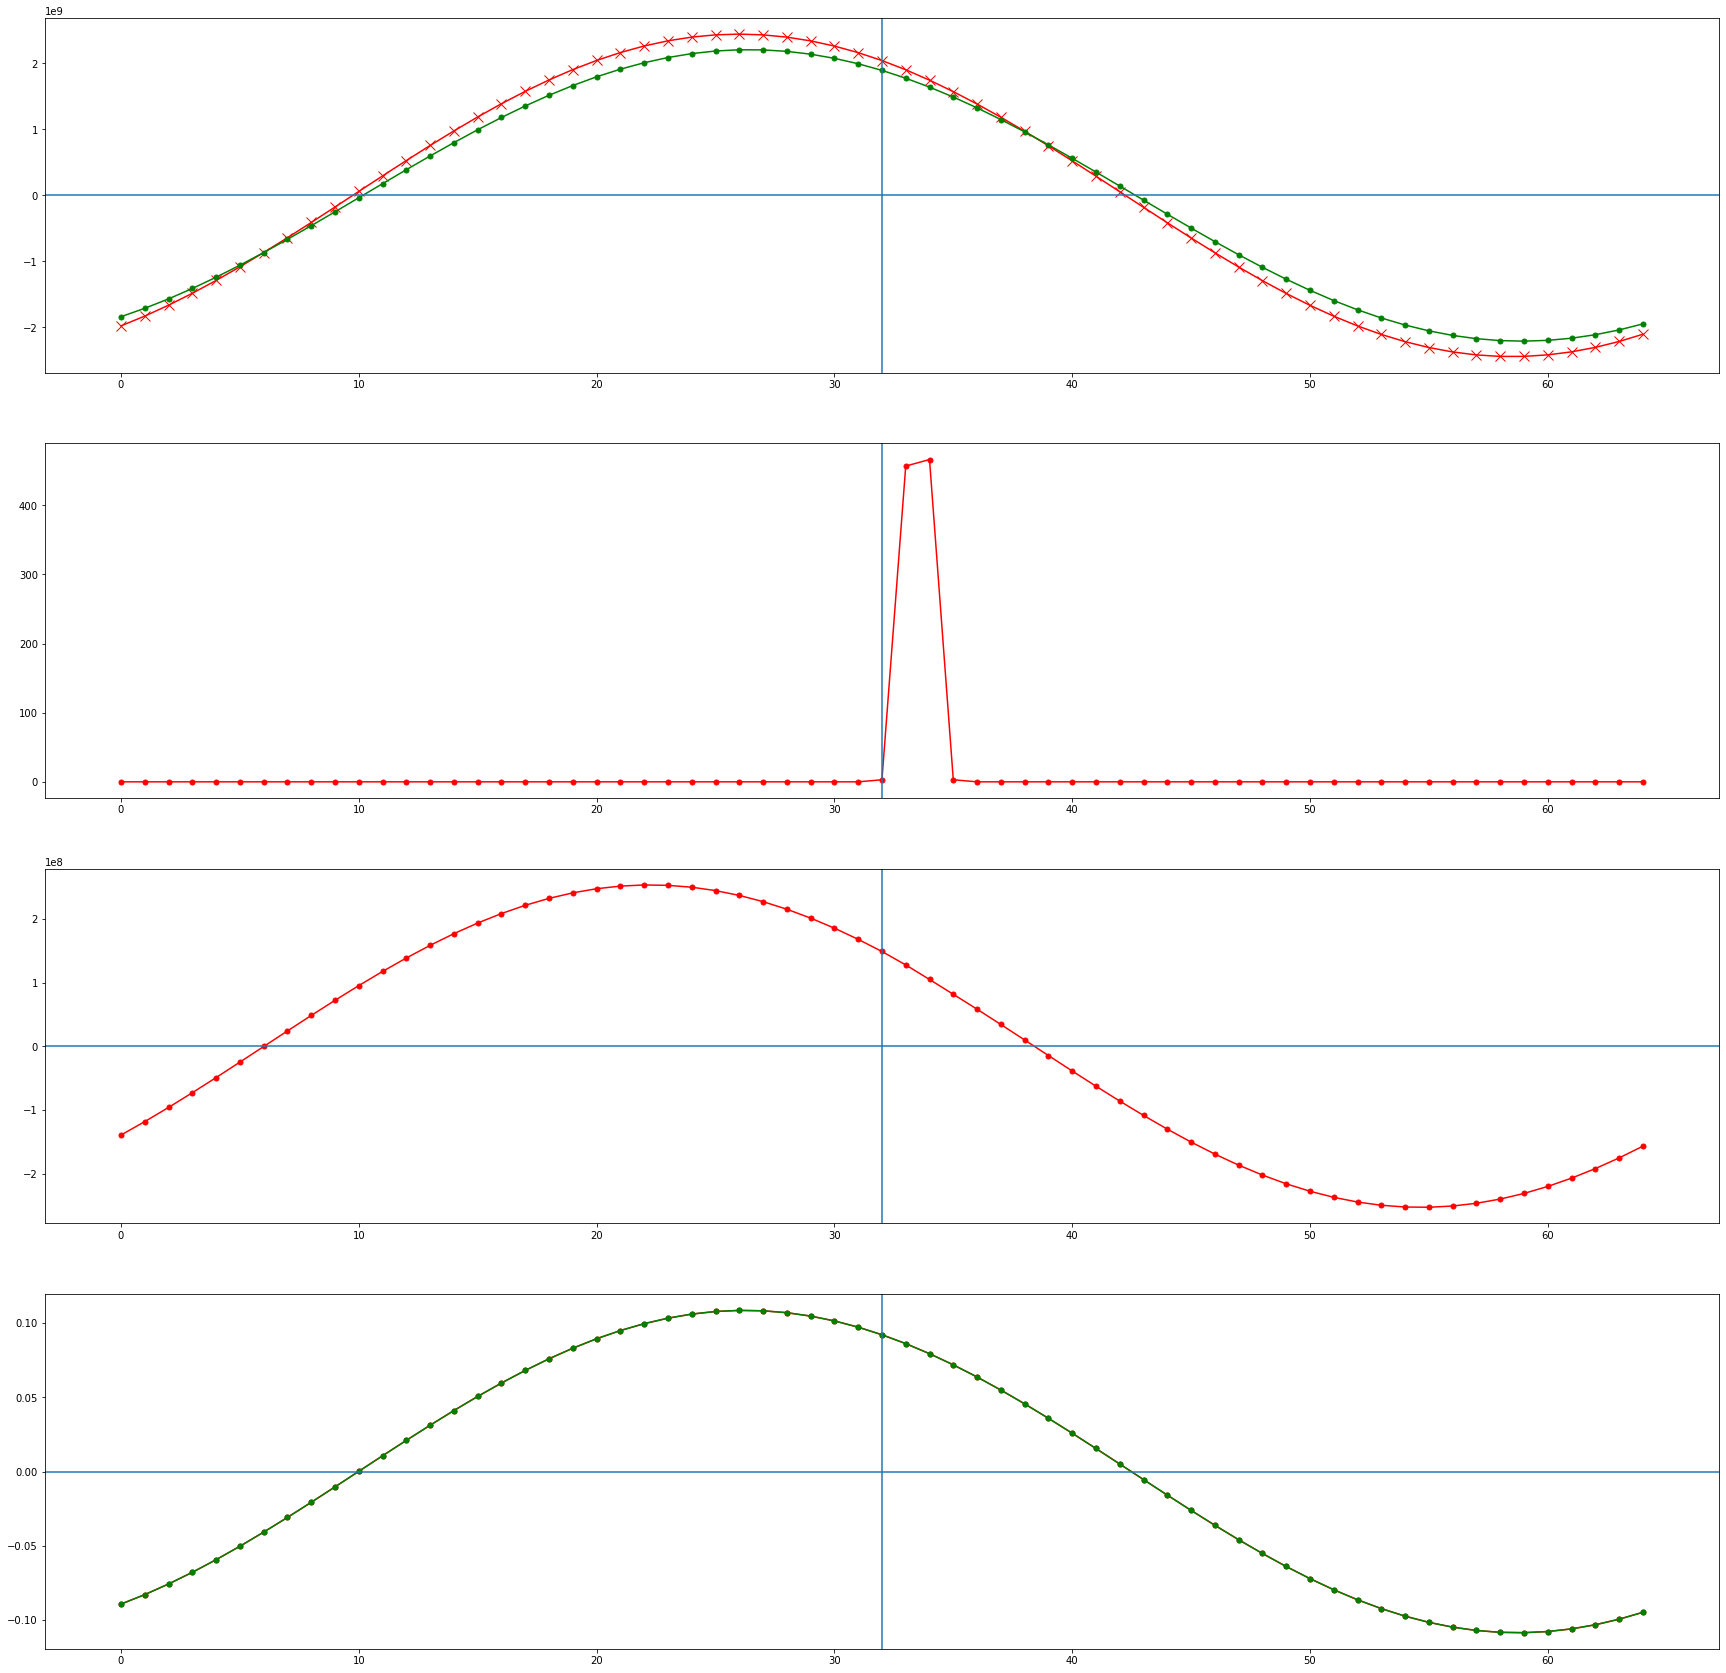

In [10]:
startTurn =5# int(nTurns/step-1)
startRF = 7*fill_step-0
nRFsamp = 1

ult.plot_VI(startTurn,startRF,nRF,nRFsamp,NpRF,nBeam,h,V,Vref,Iref,Ig,Ibi,Ibi2,cwd)

In [11]:
# get the synchronous phase
M1_all = array('d')
M1_fn = 'M1_all.bin'
datafile = os.path.join(cwd,M1_fn)    
with open(datafile, mode='rb') as file: # b is important -> binary
    M1_all.fromfile(file,2*nTurns*nBeam*nBunch)
M1_1 = []
M1_2 = []
for i in range(nTurns):
    for j in range(nBunch):
        M1_1.append(M1_all[i*nBunch*2+j])
        M1_2.append(M1_all[i*nBunch*2+nBunch+j]-Gamma0)

In [12]:
turn_to_look = 500

data_point_inVI = int(turn_to_look/step)
M1_1_x = np.array([i for i in M1_1[turn_to_look*nBunch:(turn_to_look+1)*nBunch]/dt[0]])

M1_1_bin = np.array([int(i) for i in M1_1[turn_to_look*nBunch:(turn_to_look+1)*nBunch]/dt[0]])

# voltage at bunch center
V_B = np.ndarray((nRF,nBunch))
V_B_dot = np.ndarray((nRF,nBunch))
Phis = np.ndarray((nRF,nBunch))
for iRF in range(nRF):
    for iBin in range(len(M1_1_bin)):
        V_B[iRF][iBin] = V[iRF][data_point_inVI*h[0]*NpRF+M1_1_bin[iBin]]*(1-M1_1_x[iBin]+M1_1_bin[iBin])+\
                        V[iRF][data_point_inVI*h[0]*NpRF+M1_1_bin[iBin]+1]*(M1_1_x[iBin]-M1_1_bin[iBin])
        V_B_dot[iRF][iBin] = (V[iRF][data_point_inVI*h[0]*NpRF+M1_1_bin[iBin]+1]-V[iRF][data_point_inVI*h[0]*NpRF+M1_1_bin[iBin]-1])/2/dt[iRF]
        Phis[iRF][iBin] = np.arctan(V_B[iRF][iBin]*omegarf[iRF]/V_B_dot[iRF][iBin])/pi*180

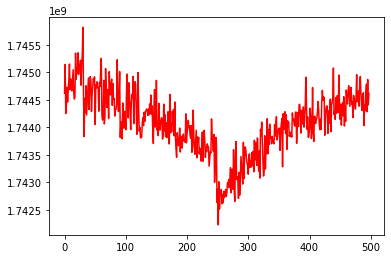

In [13]:
plt.plot(V_B[0],'r')
#plt.plot(V_B[1],'g')
#plt.plot(V_B[0]+V_B[1],'b')
plt.show()

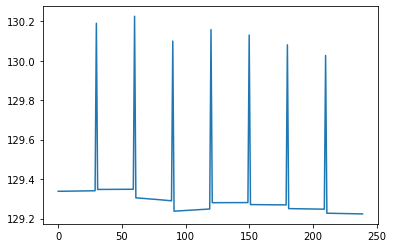

In [12]:
plt.plot(Phis[0]+180)
plt.show()
#plt.plot(Phis[1])
#plt.show()
#plt.plot(Phis[2])
#plt.show()

In [13]:
# get the stored energy
R = np.array(R)
V = np.array(V)
U = V**2/RoQ[0]/omegarf[0]
#U[1] = V[1]**2/RoQ[1]/omegarf[1]
U_bucket = np.ndarray((nRF,int(nTurns/step*h[0])))

for iRF in range(nRF):
    for iBucket in range(int(nTurns/step*h[0])):
        rng1 = iBucket*NpRF
        rng2 = rng1+NpRF*1#fill_step*1
        U_bucket[iRF][iBucket] = np.sum(U[iRF][rng1:rng2])/(rng2-rng1)
dU_bucket = U_bucket[:,1:-1]-U_bucket[:,:-2]


1734532 2168165


/home/txin/intel/oneapi/intelpython/latest/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


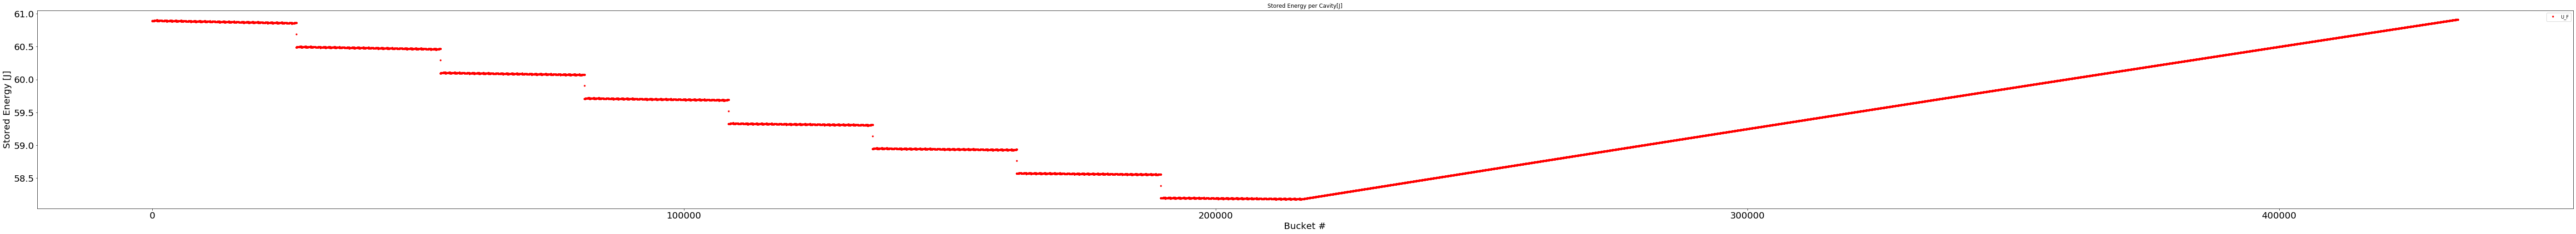

In [14]:
#plot U_bucket

fig1,axes1 = plt.subplots(1,1)
turn_to_look = 400
bunch_to_look = 0

num_of_RF_to_look = h[0]
rng1 = int(turn_to_look/step)*h[0]+bunch_to_look*fill_step
rng2 = rng1+num_of_RF_to_look#h[0]*1
print(rng1,rng2)
axes1.plot(U_bucket[0][rng1:rng2]/nCav[0],'r.')
#axes1.plot(U_bucket[1][rng1:rng2]/nCav[1],'g.')
#axes1.plot((U_bucket[1][rng1:rng2]+U_bucket[0][rng1:rng2])/(nCav[0]+nCav[1]),'b.')
#axes1.set_ylim([47,49])
axes1.set_ylabel("Stored Energy [J]",fontsize=20)
axes1.set_xlabel("Bucket #",fontsize=20)
axes1.legend(["U_F","U_D","U_tot"])
axes1.set_title("Stored Energy per Cavity[J]")
axes1.tick_params(labelsize=20)
y_labels = axes1.get_yticks()
#axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))

fig1.set_figheight(8)
fig1.set_figwidth(100)
plt.show()

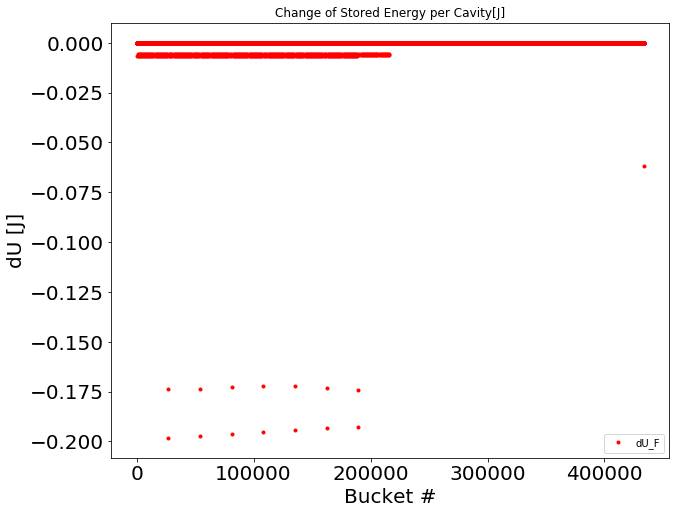

In [15]:
#plot dU_buchet

fig1,axes1 = plt.subplots(1,1)
#rng1 = int(3000/step)*h[0]
#rng2 = rng1+h[0]
#print(rng1,rng2)
axes1.plot(dU_bucket[0][rng1:rng2]/nCav[0],'r.')
#axes1.plot(dU_bucket[1][rng1:rng2]/nCav[1],'g.')
#axes1.plot((dU_bucket[1][rng1:rng2]+dU_bucket[0][rng1:rng2])/(nCav[0]+nCav[1]),'b.')
#axes1.set_ylim([47,49])
axes1.set_ylabel("dU [J]",fontsize=20)
axes1.set_xlabel("Bucket #",fontsize=20)
axes1.legend(["dU_F","dU_D","dU_tot"])
axes1.set_title("Change of Stored Energy per Cavity[J]")
axes1.tick_params(labelsize=20)
y_labels = axes1.get_yticks()
#axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))

fig1.set_figheight(8)
fig1.set_figwidth(10)
plt.show()

In [16]:
# get the beam power
Ig= np.array(Ig)
V = np.array(V)

P_B_from_VI = V*Ibi # every time step

P_B = np.ndarray((int(nTurns/step))) # average over one turn
P_B_bucket = np.ndarray((nRF,int(nTurns/step*h[0]))) # average over one bucket?

for iRF in range(nRF):
    for iBucket in range(int(nTurns/step*h[0])):
        rng1 = iBucket*NpRF
        rng2 = rng1+NpRF*2*1
        P_B_bucket[iRF][iBucket] = np.sum(P_B_from_VI[iRF][rng1:rng2])/(rng2-rng1)/1e6

for iTurn in range(int(nTurns/step)):
    rng1 = iTurn*h[0]*NpRF
    rng2 = rng1+h[0]*NpRF
    P_B[iTurn] = np.sum(P_B_from_VI[:,rng1:rng2])/(rng2-rng1)

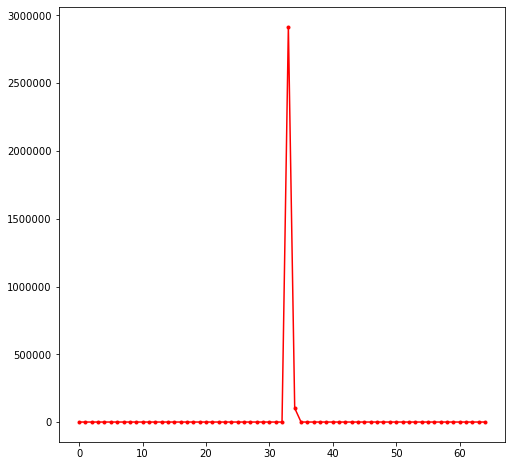

In [17]:
#plot P_B_from_VI
fig1,axes1 = plt.subplots(1,1)
rng1 = int(400/step)*h[0]*NpRF+30*fill_step*NpRF
rng2 = rng1+1*NpRF
axes1.plot(P_B_from_VI[0][rng1:rng2]/1e6,'r.-')
#axes1.plot(P_B_from_VI[1][rng1:rng2]/1e6,'g.-')
fig1.set_figheight(8)
fig1.set_figwidth(8)
plt.show()

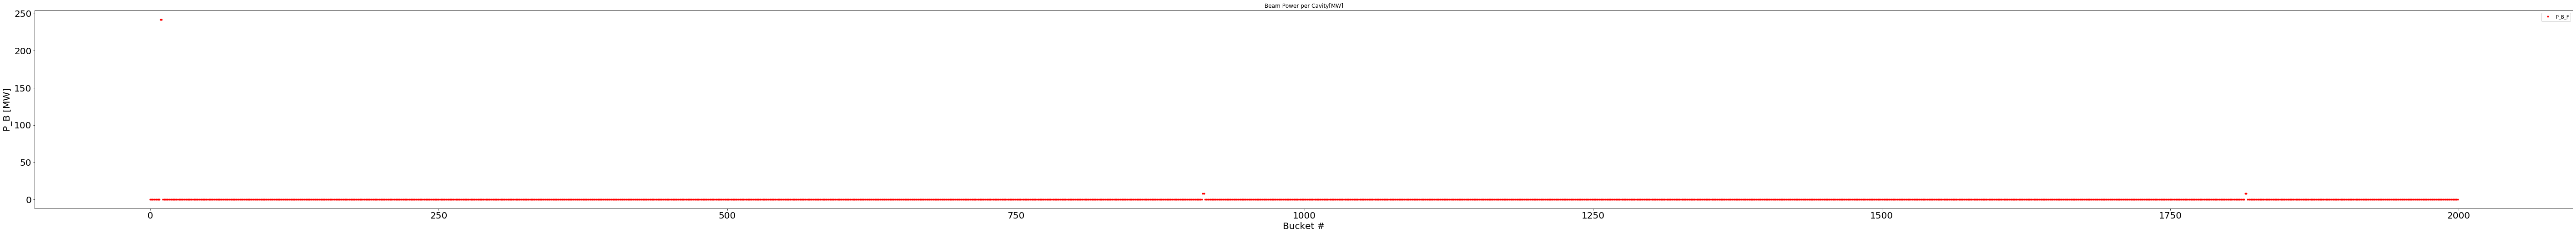

In [18]:
# Plot P_B every bucket

fig1,axes1 = plt.subplots(1,1)
turn_to_look = 400
bunch_to_look = 30

num_of_RF_to_look = 2000
rng1 = int(turn_to_look/step)*h[0]+bunch_to_look*fill_step-10
rng2 = rng1+num_of_RF_to_look#h[0]*1
axes1.plot(P_B_bucket[0][rng1:rng2]/nCav[0],'r.')
#axes1.plot(P_B_bucket[1][rng1:rng2]/nCav[1],'g.')
#axes1.plot(P_B_bucket[2][rng1:rng2]/nCav[2],'b.')

#axes1.set_ylim([0.4,0.7])
axes1.set_ylabel("P_B [MW]",fontsize=20)
axes1.set_xlabel("Bucket #",fontsize=20)
axes1.legend(["P_B_F","P_B_D"])
axes1.set_title("Beam Power per Cavity[MW]")
axes1.tick_params(labelsize=20)
y_labels = axes1.get_yticks()
#axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))

fig1.set_figheight(8)
fig1.set_figwidth(100)
plt.show()

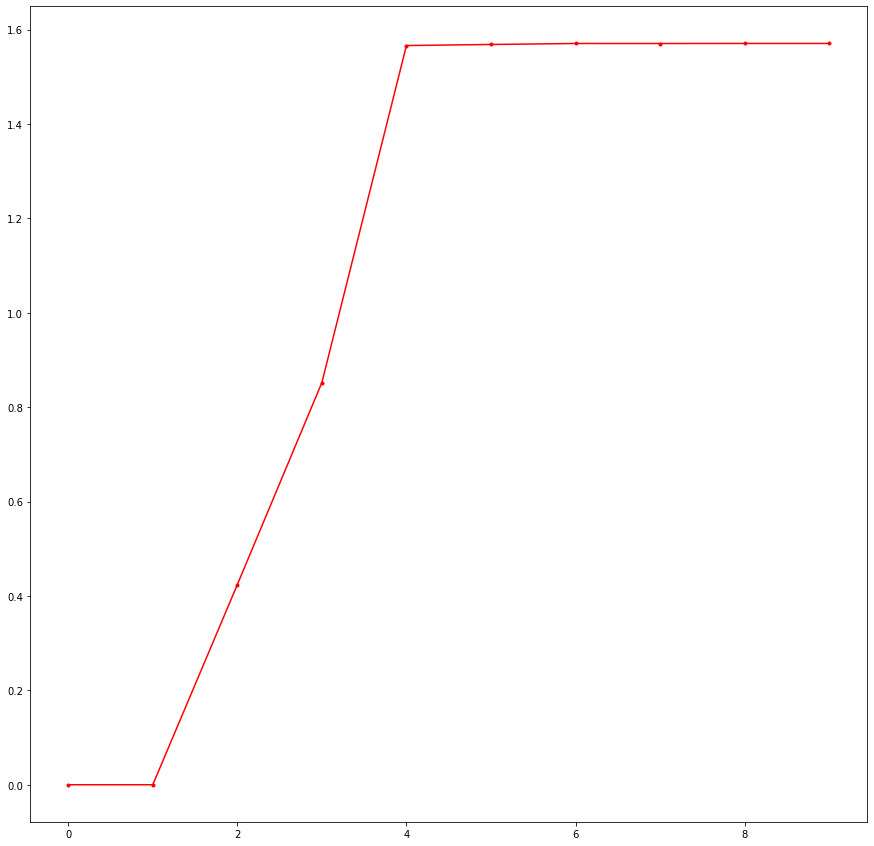

In [19]:
#plot P_B every turn
fig1,axes1 = plt.subplots(1,1)
rng1 = 0
rng2 = int(nTurns/step)
axes1.plot(P_B[rng1:rng2]/1e6,'r.-')
fig1.set_figheight(15)
fig1.set_figwidth(15)
plt.show()


In [20]:
# get the generator power, sample every rf bucket

P_G_from_VI = V*Ig/2
P_G_from_VI = Ig**2*R[0]/4
#P_G_from_VI[1] = Ig[1]**2*R[1]/4


P_G = np.ndarray((nRF,int(nTurns/step*h[0])))
for iRF in range(nRF):
    for iBucket in range(int(nTurns/step*h[0])):
        rng1 = iBucket*NpRF
        rng2 = rng1+NpRF*2#fill_step
        P_G[iRF][iBucket] = np.sum(P_G_from_VI[iRF][rng1:rng2])/(rng2-rng1)/1e6

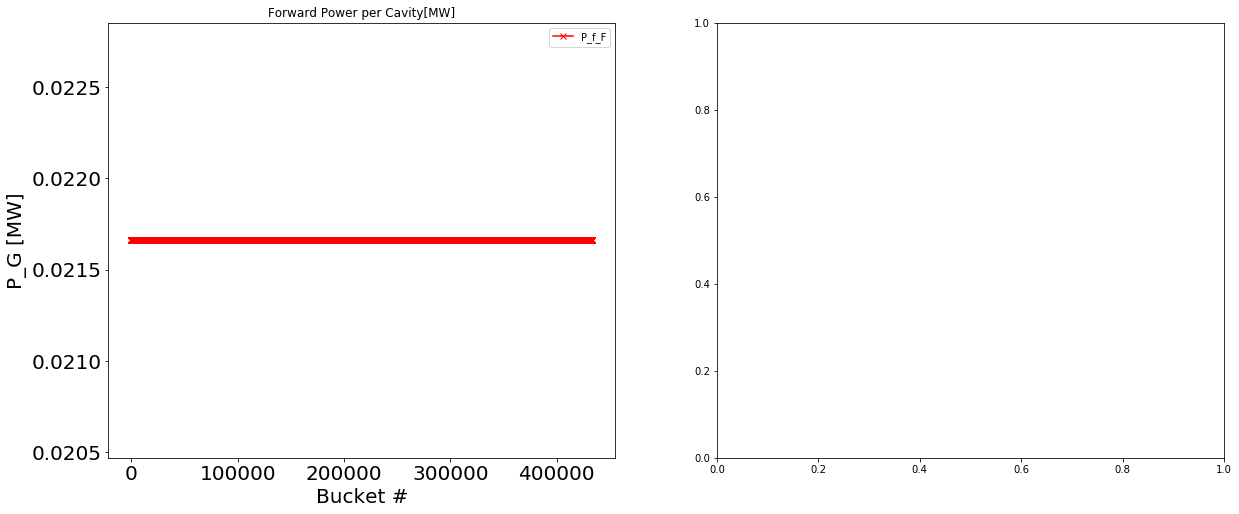

In [21]:
# plot generator forward power per bucket
fig1,axes1 = plt.subplots(1,2)
rng1 = 4*h[0]
rng2 = rng1+h[0]*1
axes1[0].plot(P_G[0][rng1:rng2]/nCav[0],'rx-')
#axes1[1].plot(P_G[1][rng1:rng2]/nCav[1],'g.-')
#axes1.plot(P_G[2][rng1:rng2]/nCav[2],'b.-')

#axes1.set_ylim([0.5,0.6])
axes1[0].set_ylabel("P_G [MW]",fontsize=20)
axes1[0].set_xlabel("Bucket #",fontsize=20)
axes1[0].legend(["P_f_F","P_f_D"])
axes1[0].set_title("Forward Power per Cavity[MW]")
axes1[0].tick_params(labelsize=20)
y_labels = axes1[0].get_yticks()
#axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))

fig1.set_figheight(8)
fig1.set_figwidth(20)
plt.show()

In [22]:
# get reflected power
Ir = V/R[0]
#Ir[1] = V[1]/R[1]
Ir = Ir-Ig/2
Pr = Ir**2*R[0]
#Pr[1] = Ir[1]**2*R[1]

# average over bucket
Pr_bucket = np.ndarray((nRF,int(nTurns/step*h[0]))) # average over one bucket?

for iRF in range(nRF):
    for iBucket in range(int(nTurns/step*h[0])):
        rng1 = iBucket*NpRF
        rng2 = rng1+NpRF*2#fill_step
        Pr_bucket[iRF][iBucket] = np.sum(Pr[iRF][rng1:rng2])/(rng2-rng1)/1e6


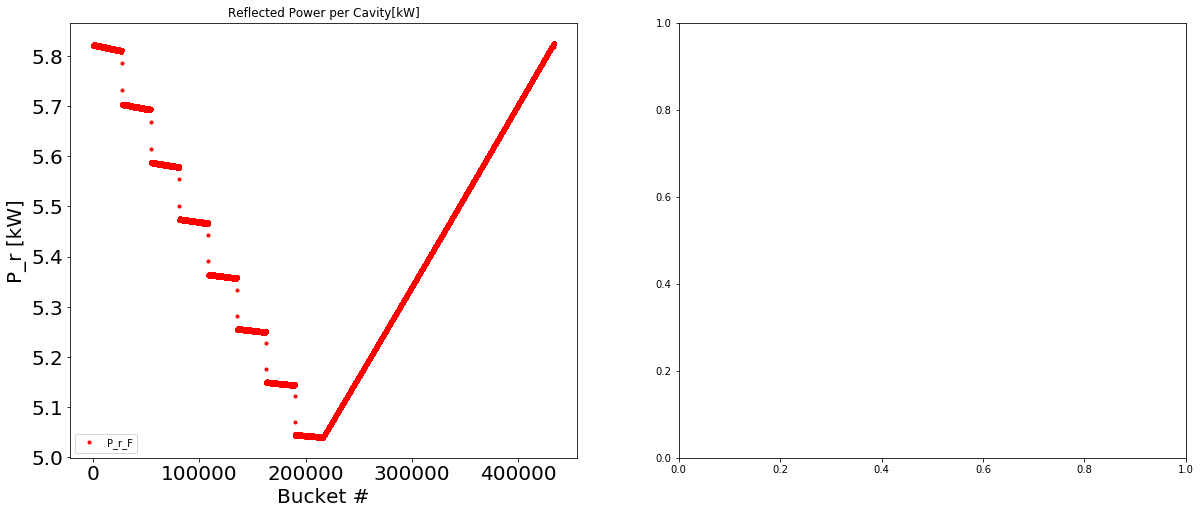

In [23]:
# plot reflected power:
fig1,axes1 = plt.subplots(1,2)
rng1 = 4*h[0]+fill_step*1*0
rng2 = rng1+h[0]
axes1[0].plot(Pr_bucket[0][rng1:rng2]/nCav[0]*1000,'r.')
#axes1[1].plot(Pr_bucket[1][rng1:rng2]/nCav[1]*1000,'g.')
#axes1.plot(Pr_bucket[2][rng1:rng2]/nCav[1]*1000,'b.')

#axes1.set_ylim([3,5])
axes1[0].set_ylabel("P_r [kW]",fontsize=20)
axes1[0].set_xlabel("Bucket #",fontsize=20)
axes1[0].legend(["P_r_F","P_r_D"])
axes1[0].set_title("Reflected Power per Cavity[kW]")
axes1[0].tick_params(labelsize=20)
y_labels = axes1[0].get_yticks()
#axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))

fig1.set_figheight(8)
fig1.set_figwidth(20)
plt.show()

               Sanity Check, is change of stored energy equals to integral of power difference?


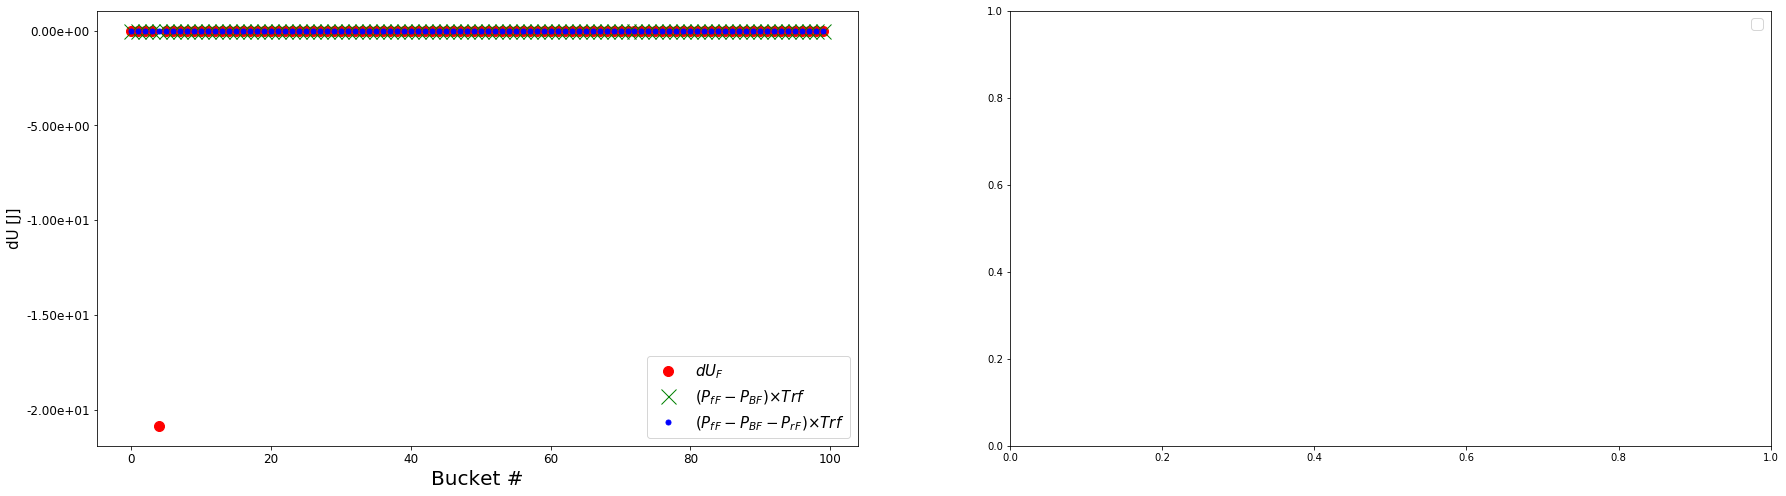

In [31]:
# energy conservation?
# Full
fig1,axes1 = plt.subplots(1,nRF+1)
turn_to_look = 400
bunch_to_look = 0

num_of_RF_to_look = 100
rng1 = int(turn_to_look/step)*h[0]+bunch_to_look*fill_step-5
rng2 = rng1+num_of_RF_to_look#h[0]*1
print("               Sanity Check, is change of stored energy equals to integral of power difference?")
for iRF in range(nRF):
    axes1[iRF].plot(dU_bucket[iRF][rng1:rng2]/nCav[iRF],'r.',ms=20)
    axes1[iRF].plot((P_G[iRF][rng1:rng2]-P_B_bucket[iRF][rng1:rng2])/(f0*h[0])*1e6/nCav[iRF],'gx',ms=15)
    axes1[iRF].plot((P_G[iRF][rng1:rng2]-P_B_bucket[iRF][rng1:rng2]-Pr_bucket[iRF][rng1:rng2])/(f0*h[0])*1e6/nCav[iRF],'b.',ms=10)
    #axes1[iRF].plot(dU_bucket[iRF][rng1:rng2]/nCav[iRF]-(P_G[iRF][rng1:rng2]-P_B_bucket[iRF][rng1:rng2]-Pr_bucket[iRF][rng1:rng2])/(f0*h[0])*1e6/nCav[iRF],'g.',ms=10)
    axes1[iRF].set_ylabel("dU [J]",fontsize=15)
    axes1[iRF].set_xlabel("Bucket #",fontsize=20)
    axes1[iRF].tick_params(labelsize=12)
    #axes1[iRF].set_ylim([0,3e-4])
    y_labels = axes1[iRF].get_yticks()
    axes1[iRF].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2e'))
    fig1.set_figheight(8)
    fig1.set_figwidth(30)
axes1[0].legend([r"$dU_F$",r"$(P_f{_F}-P_B{_F}){\times}Trf$",r"$(P_f{_F}-P_B{_F}-P_r{_F}){\times}Trf$"],fontsize=15)
axes1[1].legend([r"$dU_D$",r"$(P_f{_D}-P_B{_D}){\times}Trf$",r"$(P_f{_D}-P_B{_D}-P_r{_D}){\times}Trf$"],fontsize=15)

plt.show()

                                                    In the gap.


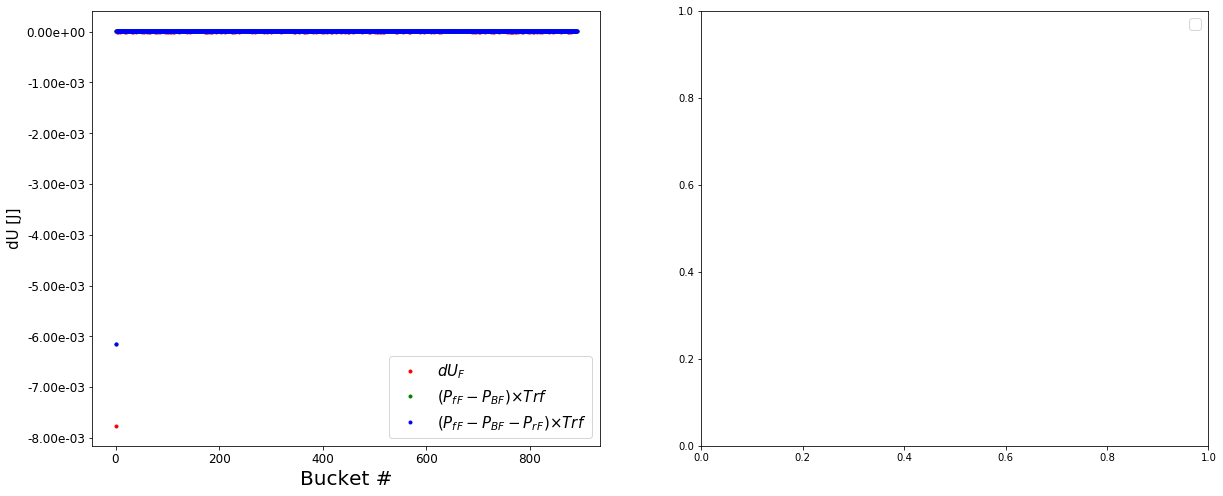

In [25]:
# energy conservation?
# in gap
fig1,axes1 = plt.subplots(1,nRF+1)
turn_to_look = 300
start_bunch = 0
end_bunch = 1

rng1 = int(turn_to_look/step)*h[0]+start_bunch*fill_step
rng2 = rng1+fill_step*(end_bunch-start_bunch)-12#7560-12
bucket_range = np.array([i for i in range(start_bunch*fill_step,fill_step*(end_bunch)-12)])
print("                                                    In the gap.")
for iRF in range(nRF):
    axes1[iRF].plot(bucket_range,dU_bucket[iRF][rng1:rng2]/nCav[iRF],'r.')
    axes1[iRF].plot(bucket_range,(P_G[iRF][rng1:rng2]-P_B_bucket[iRF][rng1:rng2])/(f0*h[iRF])*1e6/nCav[iRF],'g.')
    axes1[iRF].plot(bucket_range,(P_G[iRF][rng1:rng2]-P_B_bucket[iRF][rng1:rng2]-Pr_bucket[iRF][rng1:rng2])/(f0*h[iRF])*1e6/nCav[iRF],'b.')

    axes1[iRF].set_ylabel("dU [J]",fontsize=15)
    axes1[iRF].set_xlabel("Bucket #",fontsize=20)
    axes1[iRF].tick_params(labelsize=12)
    y_labels = axes1[iRF].get_yticks()
    axes1[iRF].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2e'))
    fig1.set_figheight(8)
    fig1.set_figwidth(20)
axes1[0].legend([r"$dU_F$",r"$(P_f{_F}-P_B{_F}){\times}Trf$",r"$(P_f{_F}-P_B{_F}-P_r{_F}){\times}Trf$"],fontsize=15)
axes1[1].legend([r"$dU_D$",r"$(P_f{_D}-P_B{_D}){\times}Trf$",r"$(P_f{_D}-P_B{_D}-P_r{_D}){\times}Trf$"],fontsize=15)

plt.show()

In [26]:
datafile = 'f_cav.bin'
datafile = os.path.join(cwd,datafile)
pattern = nRF*'d'
stride = len(pattern)*8
with open(datafile, mode='rb') as file: # b is important -> binary
    fileContent = file.read()
data = np.array([struct.unpack(pattern,fileContent[i*stride:(i+1)*stride]) for i in range(int(len(fileContent)/stride))]).T
frqs = []
for i in range(nRF):
    frqs.append(np.array(data[i])/2/np.pi)
V_max = []
Ig_max = []
for i in range(nRF):
    V_max.append([])
    Ig_max.append([])
    for j in range(int(len(V[i])/NpRF/h[0])):
        V_max[i].append(np.max(V[i][j*NpRF*h[0]:(j+1)*NpRF*h[0]]))
        Ig_max[i].append(np.max(Ig[i][j*NpRF*h[0]:(j+1)*NpRF*h[0]]))
Ig_max = np.array(Ig_max)
R = np.array(R)
Pg = Ig_max*Ig_max/8
for i in range(nRF):
    Pg[i] = Pg[i]*R[i]
Pg_tot = np.sum(Pg,0)
# to look at the power variation along the train
Pg_train = np.ndarray((int(nTurns/step),nRF,NpRF*h[0]))
for sample in range(int(nTurns/step)):
    for RF in range(nRF):
        Pg_train[sample][RF] = Ig[RF][sample*NpRF*h[0]:(sample+1)*NpRF*h[0]]*Ig[RF][sample*NpRF*h[0]:(sample+1)*NpRF*h[0]]/4*R[RF]
Pg_train_average = np.ndarray((int(nTurns/step),nRF,h[0]))

for sample in range(int(nTurns/step)):
    for RF in range(nRF):
        for bucket in range(h[0]):
            Pg_train_average[sample][RF][bucket] = np.sum(Pg_train[sample][RF][bucket*NpRF:(bucket+1)*NpRF])/NpRF

ValueError: Format 'jpg' is not supported (supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz)

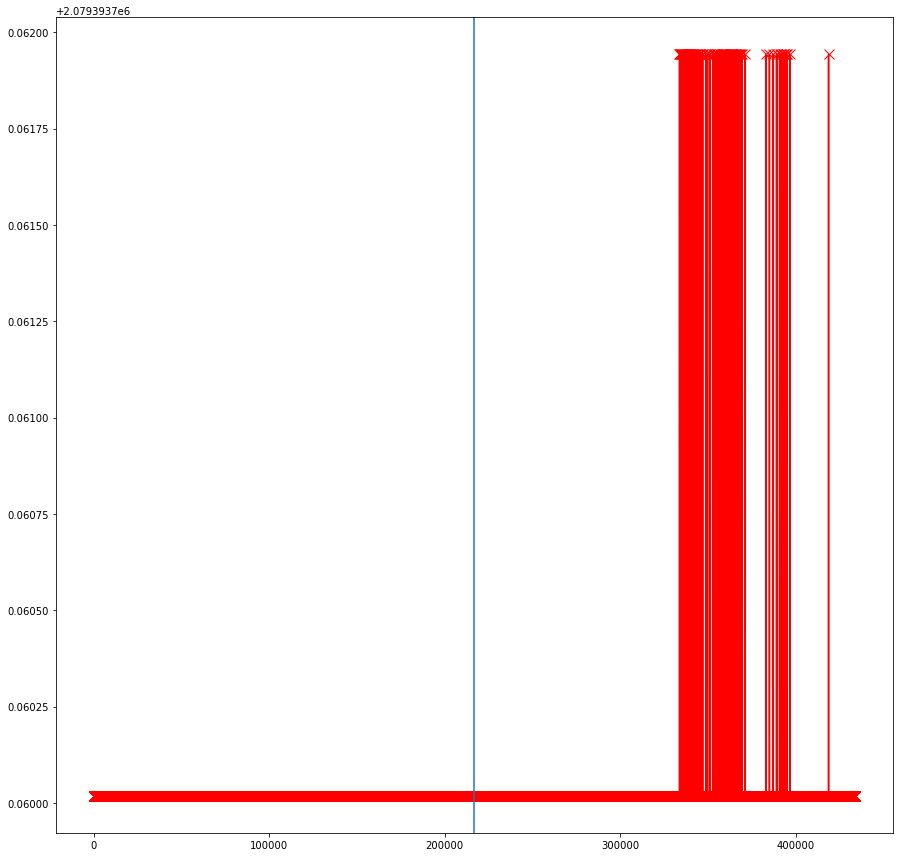

In [27]:
sample_disp = 4# the sample turn we want to see
if nRF>1:
    fig1,axes1 = plt.subplots(nRF+1,1)
    for RF in range(nRF):
        axes1[RF].plot(Pg_train_average[sample_disp][RF]/1e6,'r.-',ms=10)
        axes1[RF].axvline(x = nBunch*fill_step)
    axes1[RF+1].plot(np.sum(Pg_train_average[sample_disp]/1e6,0),'r.-',ms=10)
    axes1[RF+1].axvline(x = nBunch*fill_step)
    
else:
    fig1,axes1 = plt.subplots(1,1)
    for i in range(nRF):
        axes1.plot(Pg_train_average[sample_disp][RF],'rx-',ms=10)
        axes1.axvline(x = nBunch*fill_step)
fig1.set_figheight(15)
fig1.set_figwidth(15)
fn_VI = os.path.join(cwd,'Pg.jpg')
plt.savefig(fn_VI,bbox_inches='tight')
plt.show()

ValueError: Format 'jpg' is not supported (supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz)

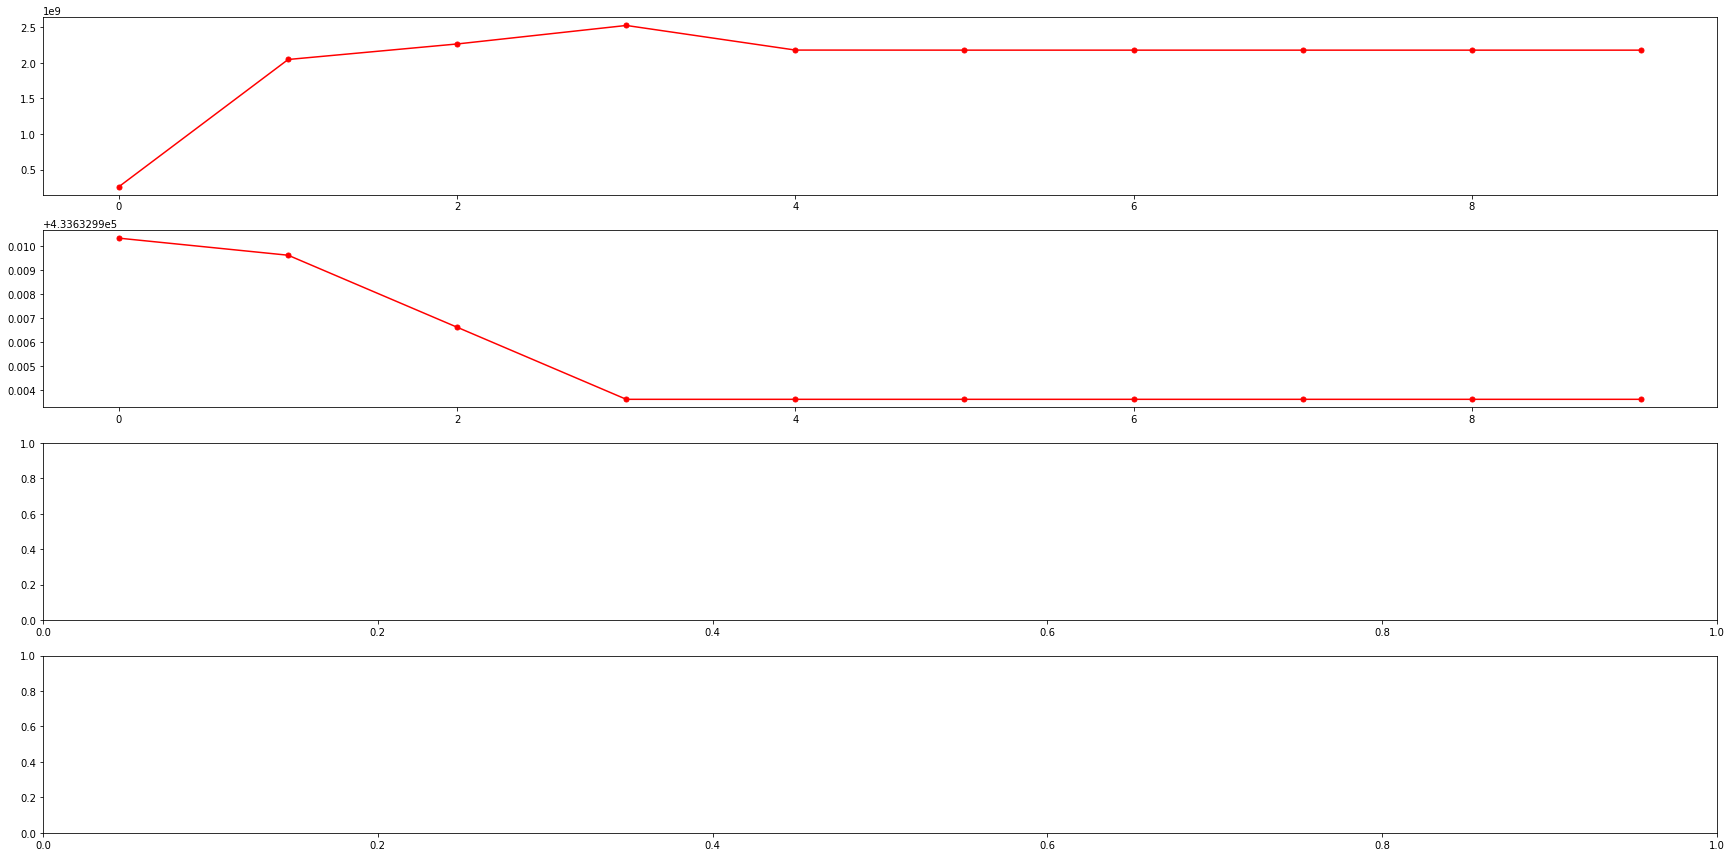

In [32]:
start = 0 # this number times n_per_step gives real turn number 
end = int(nTurns/step)
if nRF>1:
    fig1,axes1 = plt.subplots(2,nRF)
    for i in range(nRF):
        axes1[0][i].plot(V_max[i][start:end],'r.-',ms=10)
        #axes1[0][i].set_yscale('log')
        axes1[1][i].axhline(y = h[i])
        #axes1[1][i].axhline(y = omegarf[i]/(omegarf[0]/h[0])+1)
        #axes1[1][i].axhline(y = omegarf[i]/(omegarf[0]/h[0])-1)
        #axes1[2][i].plot(Ig_max[i][start:end],'r.-',ms=10)
        axes1[1][i].plot(frqs[i][start:end]/(omegarf[0]/h[0]/2/np.pi),'r.-',ms=10)        
else:
    fig1,axes1 = plt.subplots(4,1)
    for i in range(nRF):
        axes1[0].plot(V_max[i][start:end],'r.-',ms=10)
        axes1[1].plot(frqs[i][start:end]/(omegarf[0]/h[0]/2/np.pi),'r.-',ms=10)   
        #axes1[1].axhline(y = omegarf[i]/(omegarf[0]/h[0]))
        
fig1.set_figheight(15)
fig1.set_figwidth(30)

fn_proc = os.path.join(cwd,'process.jpg')
plt.savefig(fn_proc,bbox_inches='tight')
plt.show()

In [42]:
Pbeam = "{0:.2f}".format(Prad/1e6)
P_B_sim = "{0:.2f}".format(P_B[-1]/1e6)
#Pg_expected = "{0:.2f}".format(Prad*(NF/(NF+ND)/np.cos(thetaL1/180*pi)**2+ND/(NF+ND)/np.cos(thetaL2/180*pi)**2)/1e6)
Pg_max_sim = "{0:.2f}".format(Pg_tot[-1]/1e6)

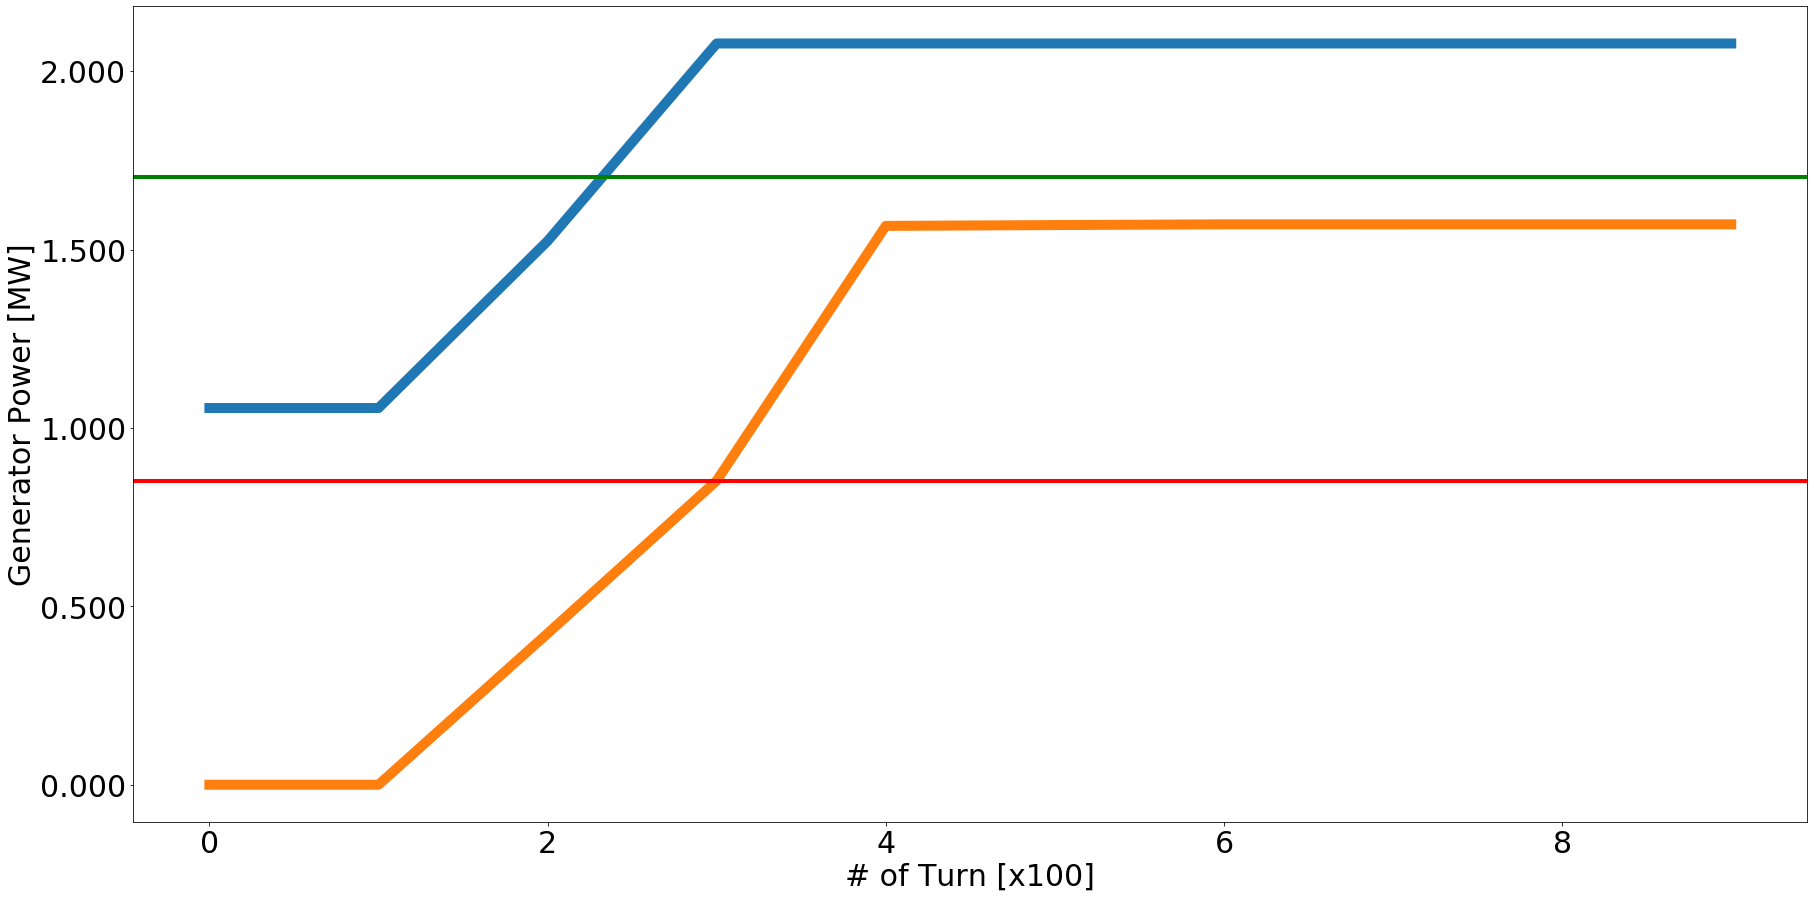

In [44]:
# plot the Power
start = 0 # this number times n_per_step gives real turn number 
end = int(nTurns/step)
fig1,axes1 = plt.subplots(1,1)
axes1.plot(Pg_tot/1e6, linewidth=10)
#axes1.axhline(y = Prad/1e6*(NF/(NF+ND)/np.cos(thetaL1/180*pi)**2+ND/(NF+ND)/np.cos(thetaL2/180*pi)**2),linewidth=4,color='g', linestyle='--')

axes1.plot(P_B/1e6, linewidth=10)

axes1.axhline(y = Prad/1e6,linewidth=4,color='r')
axes1.axhline(y = Prad/1e6*2,linewidth=4,color='g')

axes1.tick_params(labelsize=50)
axes1.set_ylabel("Generator Power [MW]",fontsize=30)
axes1.set_xlabel("# of Turn [x"+str(step)+"]",fontsize=30)
#axes1.set_title("Generator Power vs Turn, thetaL1 = "+str(thetaL1)+",thetaL2 = "+str(thetaL2)+" [degree] ",fontsize=40)
#axes1.legend(["Generator Power from simulation = "+Pg_max_sim+" [MW]", "Pb/Cos(thetaL)**2 = "+Pg_expected+" [MW]","Beam Power (simulated) = "+P_B_sim+" [MW])","Beam Power (Pb) = "+Pbeam+" [MW]"],prop={'size': 30})
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))

fig1.set_figheight(15)
fig1.set_figwidth(30)

fn_proc = os.path.join(cwd,'Pg.png')
plt.savefig(fn_proc,bbox_inches='tight')
plt.show()

In [35]:
def smooth(data,n):
    data_temp = np.zeros(len(data))
    step = int(n/2)
    data_temp[:step+1] = data[:step+1]
    for i in range(n):
        data_temp[step:len(data)-step] += data[i:len(data)-n+i+1]
    return data_temp/n


In [36]:
Ib_smooth = smooth(Ibi,3)

ValueError: Format 'jpg' is not supported (supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz)

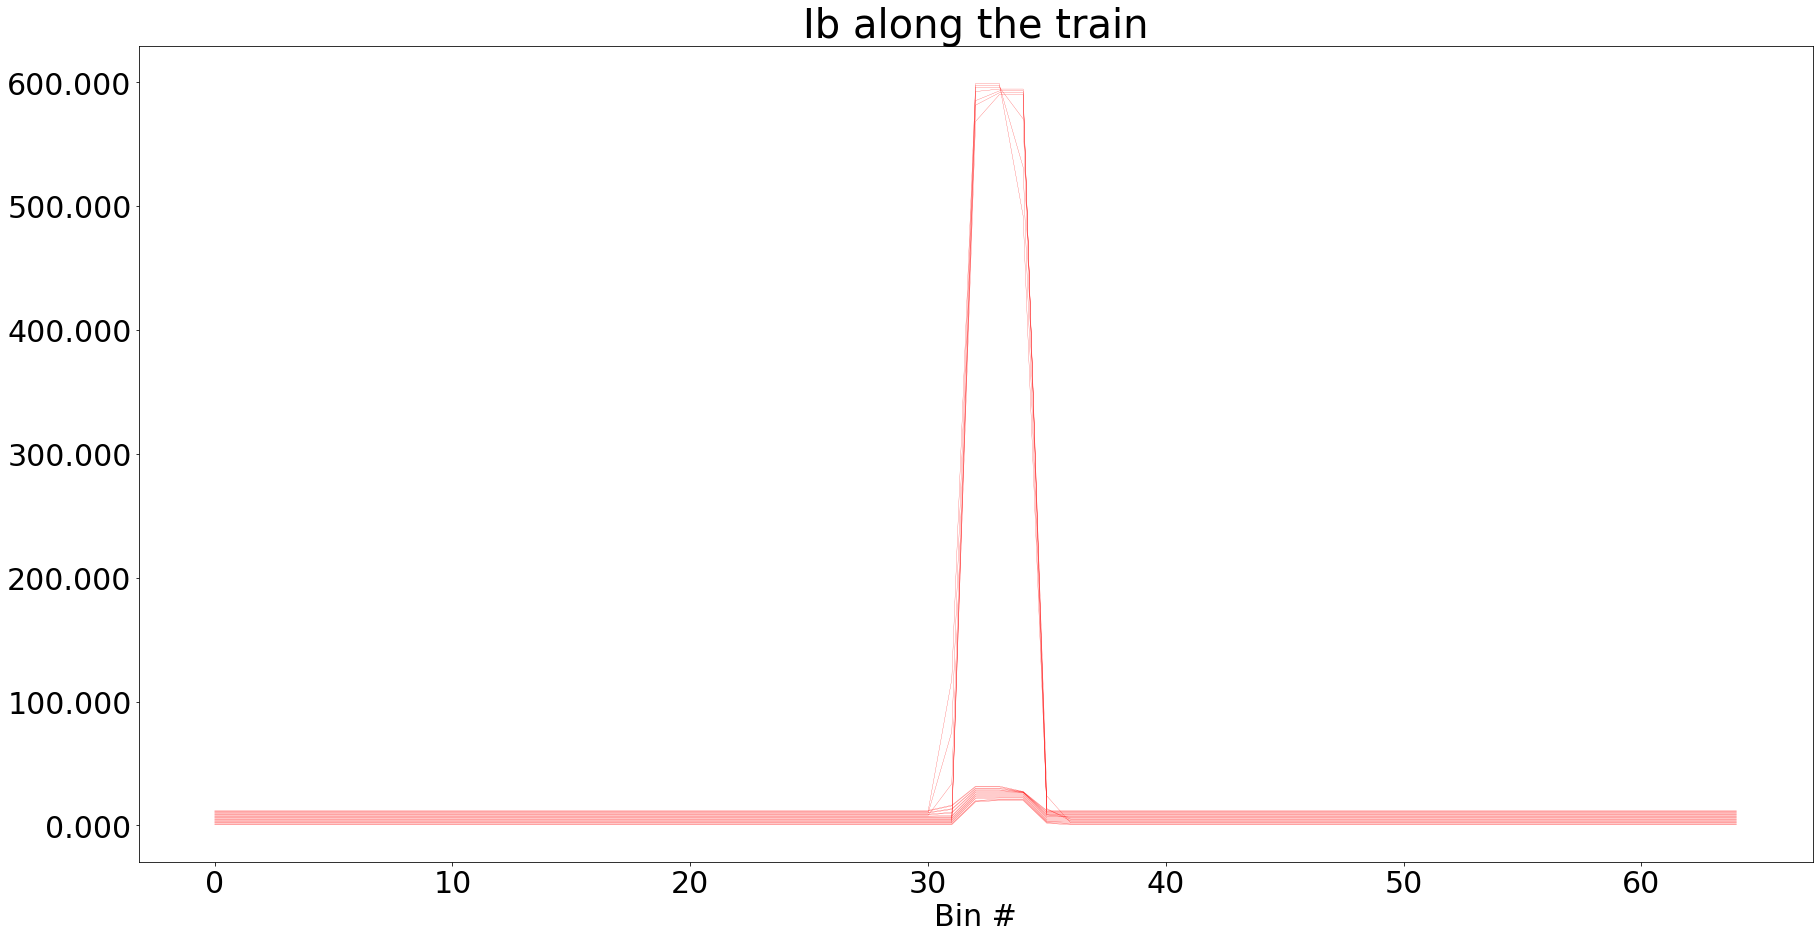

In [37]:
# range plot
turn_disp = 4
fig1,axes1 = plt.subplots(1,1)
nBunch_disp = int(nBunch/10)
bunch_disp_step = int(nBunch/nBunch_disp)
rng3 = 0

for bunch in range(nBunch_disp):
    rng1 = turn_disp*h[0]*NpRF+(nBunch_disp-bunch-1)*bunch_disp_step*NpRF*fill_step
    rng2 = rng1+NpRF
    bins = np.array([rng3+i for i in range(NpRF-rng3*2)])
    axes1.plot(bins,Ib_smooth[rng1+rng3:rng2-rng3]+(nBunch_disp-bunch)*0.5,'r-',ms = 0.2,linewidth=0.2)

axes1.tick_params(labelsize=50)
axes1.set_xlabel("Bin #",fontsize=30)
axes1.set_title("Ib along the train",fontsize=40)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))

fig1.set_figheight(15)
fig1.set_figwidth(30)

fn_proc = os.path.join(cwd,'range_plot.jpg')
plt.savefig(fn_proc,bbox_inches='tight')
plt.show()

In [ ]:
h

In [ ]:
(omegac-np.array(h)*f0*2*pi)/2/pi

In [ ]:
NC =14
NF = 7
ND = NC-NF

Vs = 3.7e6/NC
Vq = np.sqrt((23.7e6/NC)**2-Vs**2)
V0 = np.sqrt(Vs**2+Vq**2)
PhiPhasor0 = np.arctan(Vq/Vs)


#Vsnew = Vs
#Vqnew = Vq*NC/(NF-ND)
#V0new = np.sqrt(Vsnew**2+Vqnew**2)

VF = 3.4e6
VD = 0.1e6

VF = VF*NF
VD = VD*ND
V0 = V0*NC
PhiPhasor1 = PhiPhasor0+np.arccos((VF**2+V0**2-VD**2)/(2*VF*V0))
print("New Phasor angle : ",PhiPhasor1/pi*180)

In [ ]:
nRF = 2
f0 = 78196.2883627698
f = 7560*78e3
N_thetaL = np.zeros(nRF)
dThetaL = np.zeros(nRF)
Vreftot_per_cav = np.array([4870005,4870005])
Vs = np.array([2.16e5,2.16e5])
Vq = np.array([4.865e6,-4.865e6])
IbDC = 2.5
NC = np.array([12,6])
QL = np.array([593517,593517])
PhisPhasor = np.arctan(Vq/Vs)


N_thetaL[0] = 100 # number of sample for thetaL, same for both frequencies if nRF = 2, namely we are scanning a squre grid
N_thetaL[1] = 100
ThetaL_min = np.zeros(nRF)#17.5
ThetaL_max = np.zeros(nRF)#17.5

ThetaL_min[0] = -20
ThetaL_max[0] = 20
ThetaL_min[1] = -20 
ThetaL_max[1] = 20 
dThetaL = (ThetaL_max-ThetaL_min)/N_thetaL
df1 = np.zeros(int(N_thetaL[0]))
thetaL1 = np.zeros(int(N_thetaL[0]))
df2 = np.zeros(int(N_thetaL[1]))
thetaL2 = np.zeros(int(N_thetaL[1]))


Rsh = np.array([37,37])*NC*QL
Vreftot = Vreftot_per_cav*NC

for thetaL_factor in range(int(N_thetaL[0])):
    thetaL1[thetaL_factor] = (ThetaL_min[0]+dThetaL[0]*thetaL_factor)/180.0*pi  # angle between Ig and Vc
    Vbr = 2*IbDC*Rsh
    Vgr = Vreftot/np.cos(thetaL1[thetaL_factor])*(1+Vbr/Vreftot*np.cos(PhisPhasor))

    tgPhi = -(Vbr*np.sin(PhisPhasor)/Vreftot+(1+Vbr*np.cos(PhisPhasor)/Vreftot)*np.tan(thetaL1[thetaL_factor]))
    delta_f = f*(tgPhi/2/QL+np.sqrt((tgPhi/2/QL)**2+1))-f
    
    df1[thetaL_factor] = delta_f[0]
    
    
for thetaL_factor in range(int(N_thetaL[1])):
    thetaL2[thetaL_factor] = (ThetaL_min[1]+dThetaL[1]*thetaL_factor)/180.0*pi
    Vbr = 2*IbDC*Rsh
    Vgr = Vreftot/np.cos(thetaL2[thetaL_factor])*(1+Vbr/Vreftot*np.cos(PhisPhasor))

    tgPhi = -(Vbr*np.sin(PhisPhasor)/Vreftot+(1+Vbr*np.cos(PhisPhasor)/Vreftot)*np.tan(thetaL2[thetaL_factor]))
    delta_f = f*(tgPhi/2/QL+np.sqrt((tgPhi/2/QL)**2+1))-f
    df2[thetaL_factor] = delta_f[1]

print("ThetaL1\t","df1\t\t","ThetaL2\t\t","df2\t")
for i in range(len(df1)):
    print("{0:0.1f}".format(thetaL1[i]/pi*180),"\t", "{0:0.1f}".format(df1[i]),'\t\t',"{0:0.1f}".format(thetaL2[i]/pi*180),"\t\t", "{0:0.1f}".format(df2[i]))


In [ ]:
t1 = np.ndarray((2,100))
t2 = np.ndarray((2,100))
for i in range(2):
    for j in range(100):
        t1[i][j]=(-1)**i*(i*2+j*2)
        t2[i][j]=(-1)**i*(i*2+j)
        
a = np.ndarray((2,10))
b = t1*t2

for i in range(2):
    for j in range(10):
        a[i][j] = np.sum(b[i][j*10:(j+1)*10])/10

In [ ]:
a

In [ ]:
t1

In [ ]:
t2

In [ ]:
b

In [ ]:
a